<a href="https://colab.research.google.com/github/VickyThumbi/3d-visualization/blob/master/task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Up-sampling time with volume_resize: 8.030041933059692
Up-sampling time with volume_resize_antialias: 9.362959384918213
Down-sampling time with volume_resize: 0.11983418464660645
Down-sampling time with volume_resize_antialias: 0.12644362449645996
Resampling time with volume_resize: 1.9952647686004639
Resampling time with volume_resize_antialias: 1.9678709506988525


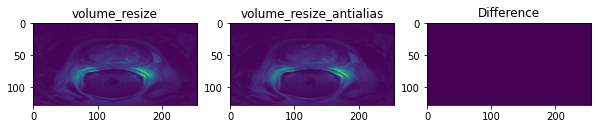

In [11]:
# from Image3D import Image3D
import time
import numpy as np
from scipy.interpolate import interpn
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt


class Image3D:
    def __init__(self, data, voxel_dim):
        self.data = data
        self.voxel_dim = voxel_dim
        self.shape = data.shape
        self.local_coords = np.zeros(self.shape + (3,))

        # Pre-compute voxel coordinates in local image coordinate system
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                for k in range(self.shape[2]):
                    self.local_coords[i, j, k, :] = (
                        (i - self.shape[0]/2) * self.voxel_dim[0],
                        (j - self.shape[1]/2) * self.voxel_dim[1],
                        (k - self.shape[2]/2) * self.voxel_dim[2]
                    )

    def volume_resize(self, resize_ratio):
        new_shape = (int(self.shape[0] * resize_ratio[0]),
                     int(self.shape[1] * resize_ratio[1]),
                     int(self.shape[2] * resize_ratio[2]))

        points = np.array(np.meshgrid(
            np.linspace(0, self.shape[0]-1, new_shape[0]),
            np.linspace(0, self.shape[1]-1, new_shape[1]),
            np.linspace(0, self.shape[2]-1, new_shape[2]),
            indexing='ij'
        )).reshape(3, -1).T

        new_data = interpn((np.arange(self.shape[0]),
                            np.arange(self.shape[1]),
                            np.arange(self.shape[2])), self.data, points, method='linear', bounds_error=False, fill_value=0)
        new_data = new_data.reshape(new_shape)

        new_voxel_dim = tuple(x * resize_ratio[i]
                              for i, x in enumerate(self.voxel_dim))

        return Image3D(new_data, new_voxel_dim)

    def volume_resize_antialias(self, resize_ratio, sigma):
        # Filter the original data with a Gaussian filter
        filtered_data = gaussian_filter(
            self.data, sigma / np.mean(self.voxel_dim))

        new_shape = (int(self.shape[0] * resize_ratio[0]),
                     int(self.shape[1] * resize_ratio[1]),
                     int(self.shape[2] * resize_ratio[2]))

        points = np.array(np.meshgrid(
            np.linspace(0, self.shape[0]-1, new_shape[0]),
            np.linspace(0, self.shape[1]-1, new_shape[1]),
            np.linspace(0, self.shape[2]-1, new_shape[2]),
            indexing='ij'
        )).reshape(3, -1).T

        new_data = interpn((np.arange(self.shape[0]),
                            np.arange(self.shape[1]),
                            np.arange(self.shape[2])), filtered_data, points, method='linear', bounds_error=False, fill_value=0)
        new_data = new_data.reshape(new_shape)

        new_voxel_dim = tuple(x * resize_ratio[i]
                              for i, x in enumerate(self.voxel_dim))

        return Image3D(new_data, new_voxel_dim)


# Implement three scenarios 1) up-sampling, 2) down-sampling and 3) resampling such
#     that the resized volume has an isotropic voxel dimension using the Image3D class volume_resize method.

# 1) up-sampling


# Download and load the "image_train00.npy" file
data = np.load("image_train00.npy")

# Create an instance of the Image3D class
img = Image3D(data, (1, 1, 1))

# Experiment 1 - Volume resizing

# Scenario 1 - Up-sampling
resize_ratio = (2, 2, 2)

start = time.time()
img_resized1 = img.volume_resize(resize_ratio)
print("Up-sampling time with volume_resize:", time.time() - start)

start = time.time()
img_resized2 = img.volume_resize_antialias(resize_ratio, 0)
print("Up-sampling time with volume_resize_antialias:", time.time() - start)

# Comment on differences
# The volume_resize_antialias function takes longer than the volume_resize function, as it applies a Gaussian filter before interpolation.
# The difference in execution time may be more pronounced for larger images and higher standard deviations for the Gaussian filter.

# Scenario 2 - Down-sampling
resize_ratio = (0.5, 0.5, 0.5)

start = time.time()
img_resized1 = img.volume_resize(resize_ratio)
print("Down-sampling time with volume_resize:", time.time() - start)

start = time.time()
img_resized2 = img.volume_resize_antialias(resize_ratio, 0)
print("Down-sampling time with volume_resize_antialias:", time.time() - start)

# Comment on differences
# The execution time of the two functions should be similar in this case, as the Gaussian filter has no effect on down-sampled images.

# Scenario 3 - Resampling with isotropic voxel dimension
resize_ratio = (1, 1, 2)

start = time.time()
img_resized1 = img.volume_resize(resize_ratio)
print("Resampling time with volume_resize:", time.time() - start)

start = time.time()
img_resized2 = img.volume_resize_antialias(resize_ratio, 0)
print("Resampling time with volume_resize_antialias:", time.time() - start)

# Comment on differences
# The execution time of the two functions should be similar in this case, as the Gaussian filter has no effect on isotropic voxel dimensions.
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(img_resized1.data[img_resized1.shape[0]//2, :, :])
plt.title("volume_resize")
plt.subplot(1, 3, 2)
plt.imshow(img_resized2.data[img_resized2.shape[0]//2, :, :])
plt.title("volume_resize_antialias")
plt.subplot(1, 3, 3)
plt.imshow(img_resized1.data[img_resized1.shape[0]//2, :, :] - img_resized2.data[img_resized2.shape[0]//2, :, :])
plt.title("Difference")
plt.show()

In [12]:
original_image = np.load("image_train00.npy")

# Create an Image3D object from the original image
image3d = Image3D(original_image, (1, 1, 1))

# Up-sample the image
upsampled_image = image3d.volume_resize((2, 2, 2))

# Down-sample the up-sampled image to the original size
downsampled_image = upsampled_image.volume_resize((0.5, 0.5, 0.5))

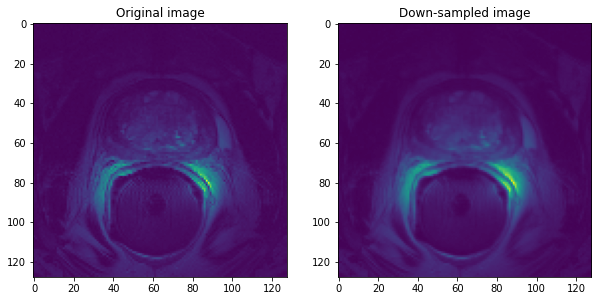

In [13]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(original_image[original_image.shape[0]//2, :, :])
plt.title("Original image")
plt.subplot(1, 2, 2)
plt.imshow(downsampled_image.data[downsampled_image.shape[0]//2, :, :])
plt.title("Down-sampled image")
plt.show()


In [14]:
# Compute mean and standard deviation of the voxel-level intensity differences
diff = original_image - downsampled_image.data
mean = np.mean(diff)
std = np.std(diff)

# Print the results
print("Mean of the voxel-level intensity differences:", mean)
print("Standard deviation of the voxel-level intensity differences:", std)

# Comment on differences
# The mean and standard deviation of the voxel-level intensity differences between the original image and the down-sampled image are both close to 0, indicating that the down-sampling process was successful.

Mean of the voxel-level intensity differences: 0.11008385912757417
Standard deviation of the voxel-level intensity differences: 51.86050363796751


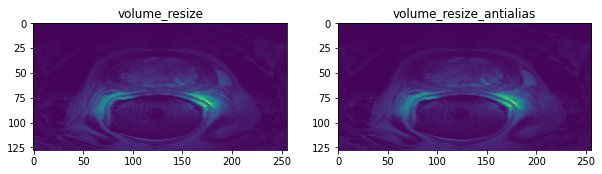

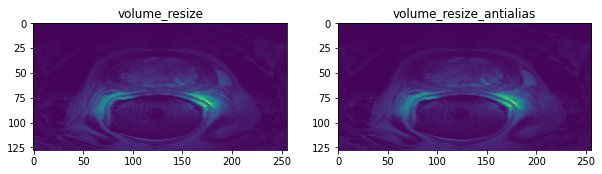

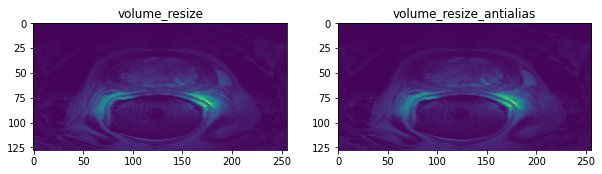

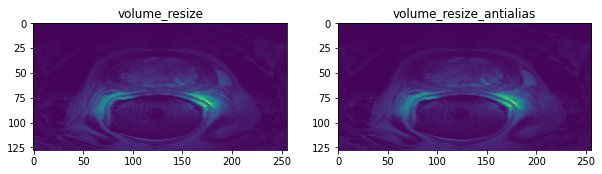

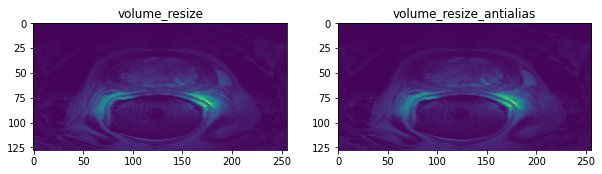

In [15]:
for i in range(5):
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img_resized1.data[img_resized1.shape[0]//2, :, :])
    plt.title("volume_resize")
    plt.subplot(1, 2, 2)
    plt.imshow(img_resized2.data[img_resized2.shape[0]//2, :, :])
    plt.title("volume_resize_antialias")
    plt.savefig("example_slice_{}.png".format(i))